In [11]:
# -----------------------------------------------------------------------------
# 1. IMPORTACIÓN DE LIBRERÍAS Y CARGA DE DATOS
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar dataset Titanic (URL directa compatible con pandas)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Vista previa
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# -----------------------------------------------------------------------------
# 2. EXPLORACIÓN INICIAL Y TIPOS DE DATOS (SECCIÓN 1.1)
# -----------------------------------------------------------------------------
# Información general y tipos de datos
print("--- INFO ---")
df.info()

print("\n--- ESTADÍSTICA DESCRIPTIVA ---")
# Transponer para mejor legibilidad
print(df.describe().T)

print("\n--- VALORES FALTANTES (SECCIÓN 1.2) ---")
# Identificar columnas con nulos para decidir estrategia en el Pipeline
print(df.isnull().sum())

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- ESTADÍSTICA DESCRIPTIVA ---
             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.4865

C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\3469651560.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='viridis')


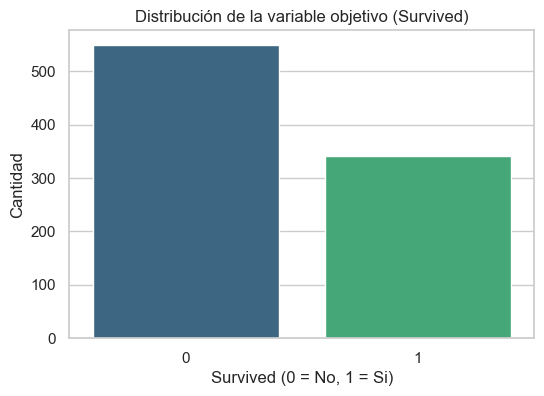

No sobrevivieron: 61.62%
Sobrevivieron: 38.38%


In [13]:
# -----------------------------------------------------------------------------
# 3. EDA: ANÁLISIS EXPLORATORIO DE DATOS (SECCIÓN 2)
# -----------------------------------------------------------------------------

# 3.1 Balance de clases (Sección 2.7)
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df, palette='viridis')
plt.title('Distribución de la variable objetivo (Survived)')
plt.xlabel('Survived (0 = No, 1 = Si)')
plt.ylabel('Cantidad')
plt.show()

# Calcular porcentaje de desbalance
survival_rate = df['Survived'].value_counts(normalize=True) * 100
print(f"No sobrevivieron: {survival_rate[0]:.2f}%")
print(f"Sobrevivieron: {survival_rate[1]:.2f}%")

C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\4275219560.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Survived', y='Fare', data=df, ax=axes[1], palette='Set2')


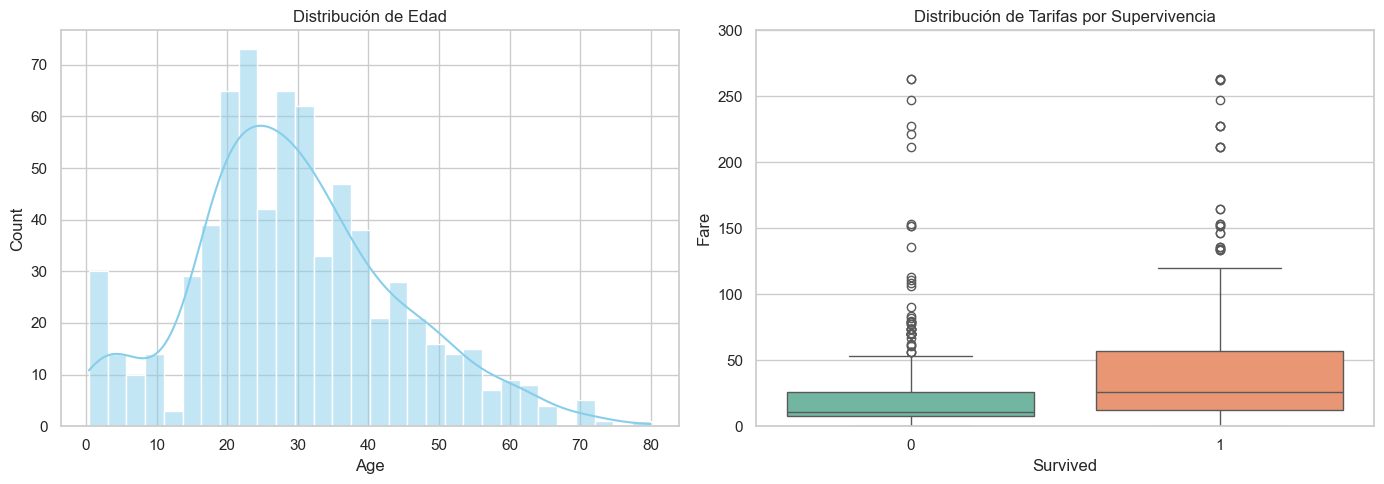

In [14]:
# 3.2 Distribuciones Univariadas y Boxplots (Secciones 2.2 y 2.3)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de Edad
sns.histplot(data=df, x='Age', kde=True, bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Edad')

# Boxplot de Tarifa vs Supervivencia (Detección de Outliers - Sección 1.3)
sns.boxplot(x='Survived', y='Fare', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Distribución de Tarifas por Supervivencia')
axes[1].set_ylim(0, 300) # Limitamos eje Y para ver mejor la caja (hay outliers extremos en Fare)

plt.tight_layout()
plt.show()

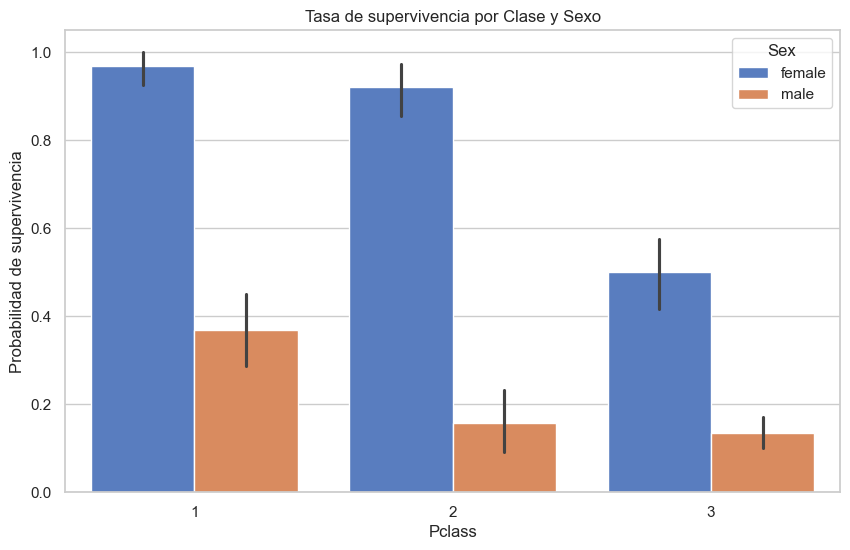

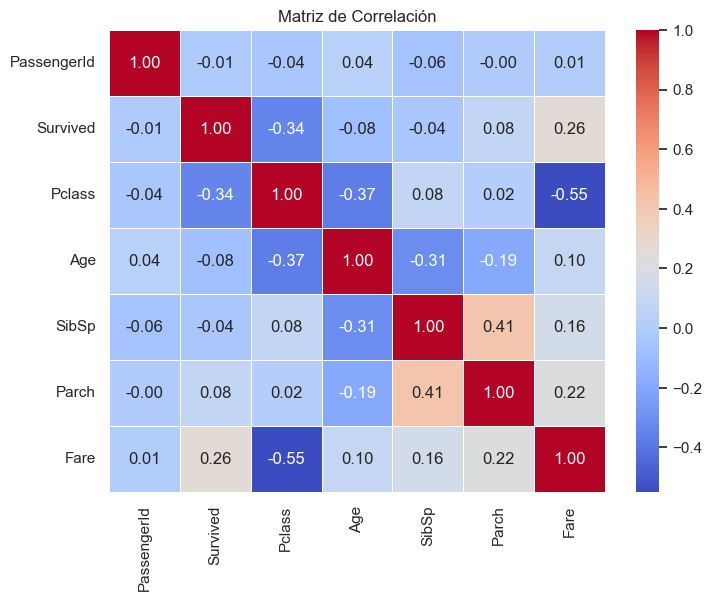

In [15]:
# 3.3 Relaciones Bivariadas y Correlación (Sección 2.4 y 2.5)
# Relación entre Clase, Sexo y Supervivencia
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df, palette='muted')
plt.title('Tasa de supervivencia por Clase y Sexo')
plt.ylabel('Probabilidad de supervivencia')
plt.show()

# Matriz de correlación (Solo variables numéricas)
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [16]:
# -----------------------------------------------------------------------------
# 4. PREPARACIÓN DE DATOS (FEATURE SELECTION & SPLIT) (SECCIÓN 3.1)
# -----------------------------------------------------------------------------

# Definición de Features y Target
# Eliminamos columnas que no aportan al modelo general (ID, Nombre, Ticket)
# Cabin tiene demasiados nulos (>75%), la descartamos por ahora.
features_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_clean = df.drop(columns=features_to_drop)

X = df_clean.drop('Survived', axis=1)
y = df_clean['Survived']

# Separación Train-Test (Estratificada para mantener proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (712, 7)
Test shape: (179, 7)


In [17]:
# -----------------------------------------------------------------------------
# 5. CONSTRUCCIÓN DEL PIPELINE (SECCIÓN 4)
# -----------------------------------------------------------------------------

# Identificar columnas numéricas y categóricas
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 5.1 Transformadores para variables Numéricas (Sección 1.2 y 1.4)
# - Imputación: Mediana (robusta a outliers)
# - Escalado: StandardScaler (importante para Regresión Logística)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 5.2 Transformadores para variables Categóricas (Sección 1.5)
# - Imputación: Moda (most_frequent)
# - Codificación: OneHotEncoder (handle_unknown='ignore' para evitar errores en producción)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # drop='first' evita multicolinealidad
])

# 5.3 ColumnTransformer: Unir ambos procesos (Sección 4.3)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5.4 Pipeline Completo con Modelo (Sección 4.2)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [18]:
# -----------------------------------------------------------------------------
# 6. OPTIMIZACIÓN CON GRIDSEARCHCV (SECCIÓN 4.4)
# -----------------------------------------------------------------------------

# Definir rejilla de hiperparámetros para tunear la Regresión Logística
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Fuerza de regularización
    'classifier__solver': ['liblinear', 'lbfgs'] # Algoritmos de optimización
}

# Configurar GridSearchCV con validación cruzada (5 folds)
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Entrenar (esto ejecuta el pipeline: imputación -> escalado -> encoding -> modelo)
print("Entrenando modelo y buscando mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

print("\nMejores parámetros encontrados:", grid_search.best_params_)
print(f"Mejor Accuracy en CV: {grid_search.best_score_:.4f}")

Entrenando modelo y buscando mejores hiperparámetros...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores parámetros encontrados: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Mejor Accuracy en CV: 0.8105


Accuracy en Test Set: 0.8045

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       110
           1       0.85      0.59      0.70        69

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



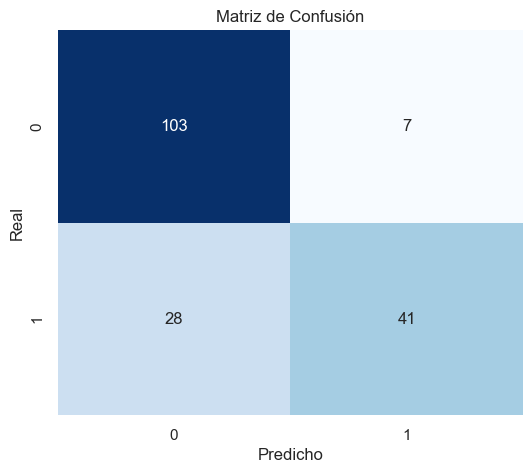

In [19]:
# -----------------------------------------------------------------------------
# 7. EVALUACIÓN DEL MODELO FINAL (SECCIÓN 3.4)
# -----------------------------------------------------------------------------

# Extraer el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones sobre el conjunto de Test (nunca visto por el modelo)
y_pred = best_model.predict(X_test)

# Métricas principales
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en Test Set: {acc:.4f}\n")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión Visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

--- Importancia de las variables (Pesos de Regresión Logística) ---
      Feature  Coefficient
6    Sex_male    -1.681518
5    Pclass_3    -0.771819
1        Fare     0.451413
0         Age    -0.314368
2       SibSp    -0.231207
7  Embarked_Q     0.226609
8  Embarked_S    -0.166637
4    Pclass_2     0.050429
3       Parch    -0.035095


C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\120290245.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


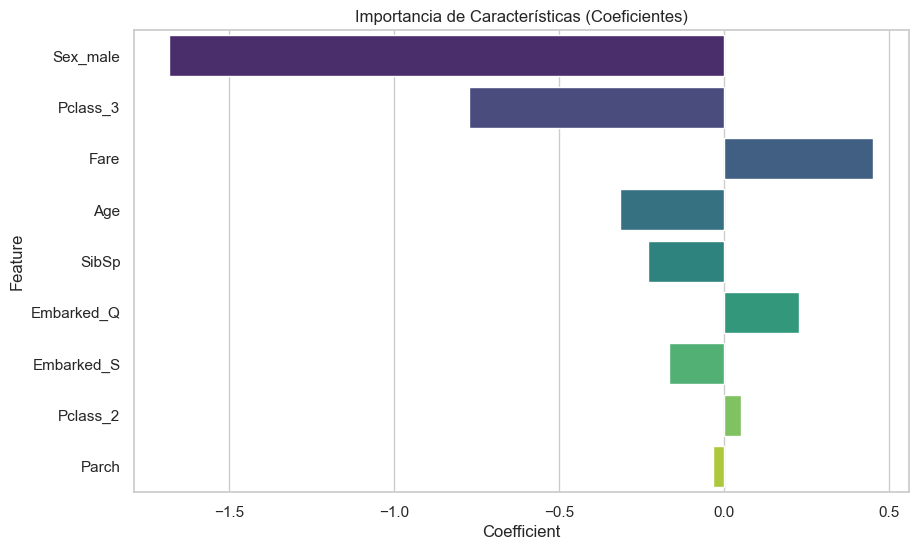

In [20]:
# -----------------------------------------------------------------------------
# 8. ANÁLISIS DE RESULTADOS E IMPORTANCIA DE VARIABLES (EXTRA)
# -----------------------------------------------------------------------------

# Obtener nombres de features tras el OneHotEncoding
# Accedemos al paso 'preprocessor', luego al transformer 'cat' y luego al 'encoder'
ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['encoder'].get_feature_names_out(categorical_features)

# Unir con nombres numéricos
all_feature_names = numeric_features + list(ohe_feature_names)

# Obtener coeficientes del modelo logístico
coefs = best_model.named_steps['classifier'].coef_[0]

# Crear DataFrame para visualizar
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("--- Importancia de las variables (Pesos de Regresión Logística) ---")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Importancia de Características (Coeficientes)')
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Asegúrate de tener las variables cargadas (df, X_test, y_test, y_pred, best_model, feature_importance)
# Si acabas de ejecutar el código anterior, ya las tienes en memoria.

# Configuración de estilo
sns.set(style="whitegrid")

# --- IMAGEN 1: balance_clases.png ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df, palette='viridis')
plt.title('Distribución de la variable objetivo')
plt.xlabel('Survived (0=No, 1=Si)')
plt.ylabel('Cantidad')
plt.savefig('balance_clases.png', dpi=300, bbox_inches='tight')
plt.close() # Cierra para no sobrecargar memoria
print("Guardada: balance_clases.png")

# --- IMAGEN 2: distribucion_edad.png ---
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', kde=True, bins=30, color='skyblue')
plt.title('Distribución de Edad')
plt.savefig('distribucion_edad.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: distribucion_edad.png")

# --- IMAGEN 3: boxplot_fare.png ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='Survived', y='Fare', data=df, palette='Set2')
plt.title('Distribución de Tarifas por Supervivencia')
plt.ylim(0, 300) # Zoom para evitar outliers extremos visualmente
plt.savefig('boxplot_fare.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: boxplot_fare.png")

# --- IMAGEN 4: correlacion_heatmap.png ---
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.savefig('correlacion_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: correlacion_heatmap.png")

# --- IMAGEN 5: sex_survival.png ---
plt.figure(figsize=(6, 5))
# Gráfico simple de tasa de supervivencia por sexo
sns.barplot(x='Sex', y='Survived', data=df, palette='muted', errorbar=None)
plt.title('Tasa de supervivencia por Sexo')
plt.ylabel('Probabilidad de supervivencia')
plt.savefig('sex_survival.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: sex_survival.png")

# --- IMAGEN 6: matriz_confusion.png ---
# Necesitas haber ejecutado el modelo para tener y_test e y_pred
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: matriz_confusion.png")

# --- IMAGEN 7: feature_importance.png ---
# Necesitas el dataframe feature_importance creado en el paso 8 del código anterior
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Importancia de Características (Coeficientes)')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()
print("Guardada: feature_importance.png")

C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\3328703352.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='viridis')


Guardada: balance_clases.png
Guardada: distribucion_edad.png


C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\3328703352.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Survived', y='Fare', data=df, palette='Set2')


Guardada: boxplot_fare.png
Guardada: correlacion_heatmap.png
Guardada: sex_survival.png


C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\3328703352.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='muted', errorbar=None)


Guardada: matriz_confusion.png


C:\Users\alexp\AppData\Local\Temp\ipykernel_7704\3328703352.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


Guardada: feature_importance.png


In [22]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import numpy as np

# --- 8.1 GRÁFICO DE VIOLÍN (Edad vs Clase vs Supervivencia) ---
# Ocupa mucho espacio y permite discutir demografía
plt.figure(figsize=(12, 8))
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df, split=True, palette='muted')
plt.title('Distribución de Edad por Clase y Supervivencia (Violin Plot)')
plt.savefig('violin_age_class.png', dpi=300, bbox_inches='tight')
plt.close()
print("Generada: violin_age_class.png")

# --- 8.2 CURVA ROC (Receiver Operating Characteristic) ---
# Muestra el rendimiento del clasificador en todos los umbrales
plt.figure(figsize=(10, 8))
ax = plt.gca()
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax, name='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
plt.title('Curva ROC')
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.close()
print("Generada: roc_curve.png")

# --- 8.3 CURVA DE APRENDIZAJE (Learning Curve) ---
# Vital para discutir Overfitting vs Underfitting (Esto llena media página de texto)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.title("Curva de Aprendizaje (Bias vs Variance Analysis)")
plt.xlabel("Ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
plt.close()
print("Generada: learning_curve.png")

# --- 8.4 ANÁLISIS DE UMBRAL (Threshold Tuning) ---
# Discusión técnica sobre cambiar el umbral de decisión de 0.5
y_probas = best_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_probas >= t).astype(int)
    from sklearn.metrics import precision_score, recall_score
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(0.5, color='k', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Score')
plt.title('Trade-off Precision-Recall según Umbral')
plt.legend()
plt.grid(True)
plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.close()
print("Generada: threshold_analysis.png")

# --- 8.5 HEATMAP DE FAMILIA (SibSp vs Parch) ---
# Nueva visualización para discutir ingeniería de características
pivot_table = df.pivot_table(index='SibSp', columns='Parch', values='Survived', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Probabilidad de Supervivencia por Tamaño Familiar')
plt.savefig('family_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()
print("Generada: family_heatmap.png")

Generada: violin_age_class.png
Generada: roc_curve.png
Generada: learning_curve.png
Generada: threshold_analysis.png
Generada: family_heatmap.png
